# Organic Photovoltaic (OPV) simulation tutorial
To run this example, additionally the GAFF forcefield will have to be installed. This can be done as follows:
```
git clone git@github.com:rsdefever/GAFF-foyer.git
cd GAFF-foyer
pip install -e .
```
_the way the GAFF repo works is through entrypoints which can be finicky--I think the -e flag is required?_

## Table of contents <a id='toc'></a>
- [Acquire a starting structure](#comp)
- [Create a simulation volume](#box)
- [Choose and apply a forcefield](#ff)
- [Run simulation](#run)
- [Analysis](#analysis)
    - [Visualize Simulation](#vis)
    - [Plotting Simulation Quantities](#plot)
    - [Radial Distribution Function](#rdf)

In [1]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
import mbuild as mb
from mbuild.formats.hoomd_simulation import create_hoomd_simulation
import parmed as pmd
import foyer
import hoomd

#TODO make these pip installable or something
from utils.cg_utils import gsd_rdf
from utils.draw_scene import snap_render, display_movie

/Users/jenny/miniconda3/envs/cmelab/lib/python3.7/site-packages/hoomd/meta.py:26: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


<a id="comp"></a>
## Starting Structure
Molecular dynamics (MD) is a way of modelling bulk atomic systems using classical (as opposed to quantum) physics. TODO make this good or link to a good explanation of MD 

In order to simulate a bulk morphology of an OPV polymer first we need a structure-- we're going to use [mbuild](https://mosdef.org/mbuild/index.html) to load a structure from a mol2 file. (Mbuild can also be used to programatically create lots of intricate structures, and for that we recommend their [tutorials](https://mosdef.org/mbuild/tutorials/tutorials.html).)

Here we've chosen a 16-mer of poly-3-hexylthiophene (P3HT).

[back to top](#toc)

In [2]:
p3ht = mb.load("moleculefiles/P3HT_16.mol2")

p3ht.visualize().show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In the above visualization, carbon atoms are colored grey, hydrogens are white, and sulfurs are yellow. Recall, MD is a classical model: it simplifies atoms to particles and bonds to harmonic oscilators (think mass on a spring). So in order to simulate the behavior of atoms in different electronic environments, instead of the computationally expensive task of modelling every electron, we simplify and use different atom "types" to represent elements in similiar electronic environments. Below is an example of the same P3HT 16-mer, but this time it is colored by the atom type assigned to it in the [General AMBER Force-Field (GAFF)](http://ambermd.org/antechamber/gaff.html).

In [3]:
# This warnings wrapper is used to silence the numerous warnings generated by the indented block
# These warnings are useful, but not for the purposes of this tutorial
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Load GAFF
    GAFF = foyer.forcefields.load_GAFF()

    # Use foyer to parameterize -- this creates a parmed structure
    p3ht_structure = GAFF.apply(p3ht, assert_dihedral_params=False)

print("Atom types: ", end="")
print(*set([atom.type for atom in p3ht_structure.atoms]), sep=", ")

gaff_colors = {
    'CC_R5': 'brown',
    'SS'   : 'yellow',
    'H4'   : 'white',
    'HA'   : 'tan',
    'C3'   : 'grey',
    'HC'   : 'black',
}
typed_p3ht = mb.clone(p3ht)

for atom_pmd, atom_mb in zip(p3ht_structure, typed_p3ht):
    atom_mb.name = atom_pmd.type

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    typed_p3ht.visualize(color_scheme = gaff_colors).show()

Atom types: cc_r5, ss, c3, h4, hc, ha


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Notice there are three different colors for hydrogen atoms and two different colors for carbon. This visualization is just to show how a forcefield is applied to a molecule, next let's create our simulation volume.

<a id="box"></a>
## Create simulation volume

MD is generally interested in the bulk properties of a material, so a simulation box with periodic boundary conditions is used. You can think of periodic boundary conditions like pacman: when a particle (pacman) exits one side of the space, he reappears on the other. 

![](images/pacman_pbc.gif)

Our periodic volume is just the same, but in three dimensions. In this way we can simulate an "infinite" volume. In the cell below, we create a box (10x10x10 nm$^{3}$), and use mbuild's `fill_box` to place 10 of our P3HT 16-mer in the box. 

[back to top](#toc)

In [4]:
box = mb.Box([10,10,10])
system_box = mb.packing.fill_box(p3ht, 10, box=box)
system_box.visualize().show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

<a id="ff"></a>
## Choose and apply forcefield
In this case the choice has been made to use GAFF because (1) it is parameterized for organic molecules--like our OPVs--and (2) a forcefield repository has already been made! A [foyer](https://mosdef.org/foyer/) forcefield repo contains an xml with force parameters and particle types with [SMARTS](https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html) definitions which allows for automatic type detection. Without this convenience, a simulator would need to decide on the type for each atom and manually rename them. Programmatic typing with version-controlled forcefield xmls is an important step towards [TRUE simulations](https://arxiv.org/abs/2003.02031).

We have already seen how applying the GAFF forcefield to one of the 16-mers changes the atom typing. Now we need to apply the force-field to the entire system. 

_Side note: The `foyer.Forcefield.apply` function currently generates a [parmed structure](https://parmed.github.io/ParmEd/html/structure.html), which does not have the same convenient system-building operations as mbuild. This is why we can't fill the box with our typed molecule. The typed molecule was shown above simply to demonstrate which atoms are assigned the different types. With the new [GMSO](https://gmso.mosdef.org/en/latest/) back-end, this workflow may change._

[back to top](#toc)

In [5]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    GAFF = foyer.forcefields.load_GAFF()
    box_struc = GAFF.apply(system_box, assert_dihedral_params=False)

<a id="run"></a>
## Run simulation

Now that we have our simulation volume, we can set up our MD simulation to run in [HOOMD](https://hoomd-blue.readthedocs.io/en/stable/) using mbuild's `create_hoomd_simulation` funciton. This will read in the atom positions, bonding information, and forcefield parameters that we have already set. Additionally we need to tell HOOMD about the temperature ([kT, really the thermal energy](https://hoomd-blue.readthedocs.io/en/stable/units.html)), the thermostat coupling (tau), the cutoff where the particles no longer "feel" each other (r_cut), and the time step (dt). Everything else set in the cell below is telling HOOMD how often/when to write out data. The [gsd](https://gsd.readthedocs.io/en/stable/) files will contain the simulation snapshots and the log file will record quantities as the simulation progresses. 

_(the cell below takes about 10 mins to run on 1.6GHz dual-core Intel Core i5)_

[back to top](#toc)

In [6]:
create_hoomd_simulation(box_struc, r_cut=1.2, auto_scale=True)

log_quantities = ["time", "temperature", "potential_energy"]
_all = hoomd.group.all()
hoomd.md.integrate.mode_standard(dt=0.0001)
integrator = hoomd.md.integrate.nvt(group=_all, kT=1.0, tau=1)
hoomd.dump.gsd("opv_trajectory.gsd", period=1e4, group=_all, overwrite=True)
hoomd.analyze.log("opv_out.log", log_quantities, period=100, overwrite=True)
hoomd.run(1e5)

HOOMD-blue 2.9.0 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 05/18/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Lui, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 4020 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 3 exclusions             : 180
notice(2): Particles with 4 exclusions             : 2080
notice(2): Particles with 6 exclusions             : 180
notice(2): Particles with 7 exclusions             :

<a id="analysis"></a>
## Analysis
Now that we have a finished simulation, we can run some analysis.

[back to top](#toc)

<a id='vis'></a>
### Visualise Simulation
First let's see what's actually going on in our simulation. This can be done in [VMD](https://www.ks.uiuc.edu/Research/vmd/) or we can use the `display_movie` and `snap_render` functions which are wrappers for [fresnel](https://fresnel.readthedocs.io/en/stable/), an open-source ray-tracer.

In [7]:
gsdfile = "opv_trajectory.gsd"
gaff_colors_cpk = {
    'cc_r5': 'grey',
    'ss'   : 'yellow',
    'h4'   : 'white',
    'ha'   : 'white',
    'c3'   : 'grey',
    'hc'   : 'white',
}

display_movie(
    snap_render, gsdfile, color=gaff_colors_cpk, gif="images/opv_trajectory.gif", height=35
)

This simulation is just designed to be a quick introduction, but we can see that this trajectory probably wasn't run long enough for the polymers to equilibrate.

![](images/opv_trajectory.gif)

<a id='plot'></a>
### Plotting simulation quantities

Another way to determine if your simulation is equilibrated is to plot the quantities from the logfile. In the above example we logged timestep (logged by default), time, temperature, and potential_energy.

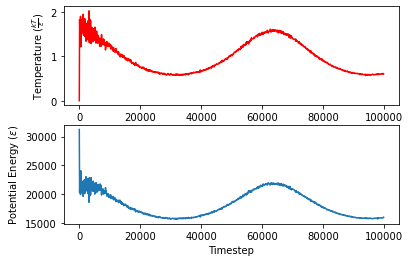

In [8]:
log_data = np.loadtxt("opv_out.log", skiprows=1)
timestep = log_data[:,0]
temp = log_data[:,2]
potential = log_data[:,3]

fig, (ax1,ax2) = plt.subplots(2)
ax1.plot(timestep,temp, 'r-')
ax1.set_xlabel("Timestep")
ax1.set_ylabel(r"Temperature ($\frac{kT}{\epsilon}$)")

ax2.plot(timestep,potential)
ax2.set_xlabel("Timestep")
ax2.set_ylabel(r"Potential Energy ($\epsilon$)");

From the above plot we can see the potential energy and temperature appear to be oscillating, which suggests the system is not equillibrated and there are likely problems with the thermostat coupling (tau). To learn how to fix this issue, check out the temperature-thermostat notebook in this repo.

<a id='rdf'></a>
### Radial Distribution Function (RDF)

<img src="http://www.physics.emory.edu/faculty/weeks/idl/pics/gr1.gif" width="200" height="200" /> <img src="http://www.physics.emory.edu/faculty/weeks/idl/pics/gr2c.gif" width="250" height="250" />

Image credit [Emory University Physics](http://www.physics.emory.edu/faculty/weeks/idl/gofr.html)

The radial distribution function calculates the distribution of nearest neighbors for each particle. It can be used to determine the phase (solid, liquid, gas) of a system or degree of crystalinity. The above image shows the RDF for the black particle in the center.

The `gsd_rdf` function is a wrapper for [freud](https://freud.readthedocs.io/en/stable/)'s rdf class. Below we are calculating the RDF between the thiophene sulfurs. 

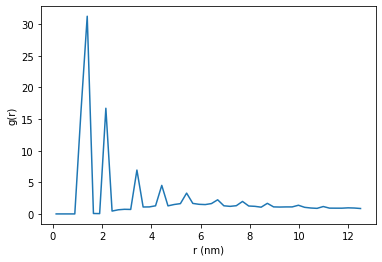

In [10]:
rdf = gsd_rdf("opv_trajectory.gsd", "ss", "ss", start=-10)
plt.plot(rdf.bin_centers, rdf.rdf)
plt.xlabel("r (nm)")
plt.ylabel("g(r)")
plt.show()

Because this trajectory is not equilibrated, this RDF is most likely showing the intrachain sulfur to sulfur distances which are controlled by the bonding forces as opposed to the more interesting interchain distances which could tell us more about $\pi-\pi$-stacking and the morphology in general. 

<img src="https://www.researchgate.net/profile/Francis_Spano/publication/263704875/figure/fig7/AS:325430251933714@1454600026675/4-4-p-stack-showing-the-intra-and-interchain-interactions-We-assume-a-square-lattice.png" width="250" height="250" />

Image from [Pochas, C.; Spano, F. **2014** *J. Chem. Phys.*](https://doi.org/10.1063/1.4882696)

For more on calculating RDFs and how to interpret them check out the RDF notebook in this repo.